In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __init__ import *
import numpy as np
from export.saver import read_pickle, save_pickle
from read.svg_reader import SVGReader
from helpers.helpers import filter_none
from placement2.attract import *
from visuals.plotter import plot_general
from copy import deepcopy
import networkx as nx
from itertools import pairwise, accumulate, product
from functools import reduce
from operator import add
from helpers.helpers import sort_and_group_objects
from domains.domain import Domain
from placement2.neighbors import *
from placement2.connectivity import *
from fixes.id_problems import report_problems
from new_solutions.selection import *
from helpers.layout import Layout
import plotly.io as pio
from icecream import ic


In [3]:
# layout: Layout = read_pickle("overlap_1011")
# layout

In [4]:
# plot_general(layout.domains)

In [5]:
# report_problems(layout)[0].action_details

In [102]:
case  = "amber_b_f01.svg"
sv = SVGReader(case)
sv.run()
domains = sv.layout.domains
pos = create_pos(domains)


No reference for svg to meters conversion!! 


In [105]:
plot_general(sv.layout.domains)


In [106]:
ad, graphs = adjust_domains(domains)
Gx, Gy = graphs

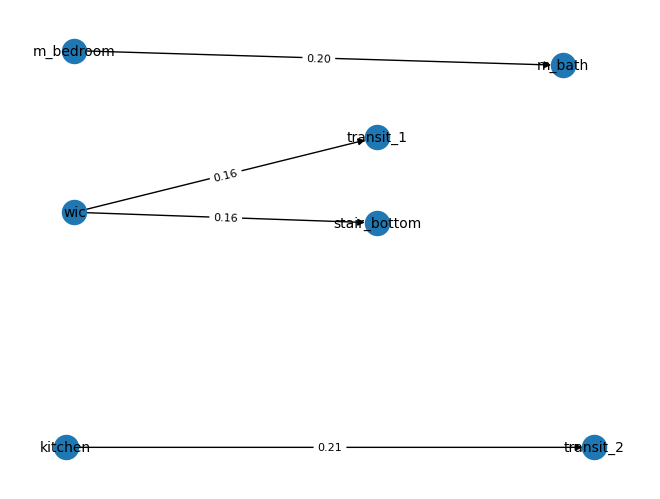

In [109]:
draw_digraph(Gx, domains )

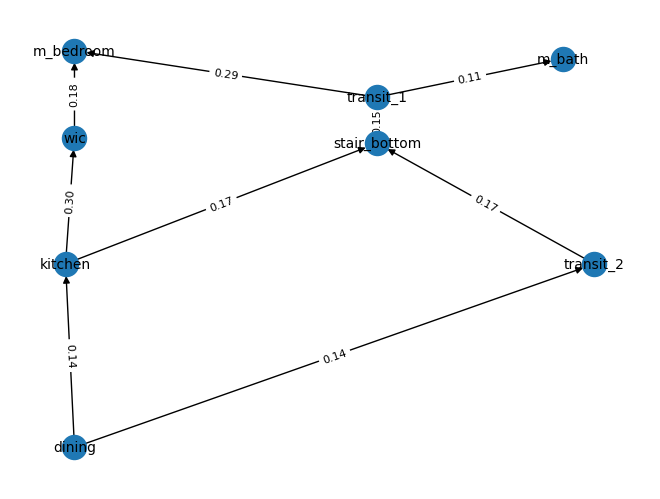

In [110]:
draw_digraph(Gy, domains )

In [107]:
plot_general(ad)

In [11]:
from typing import Iterable


def uniter(iterer: Iterable):
    return [i for i in iterer]

In [12]:
from networkx import NetworkXError
from helpers.helpers import chain_flatten


def filter_kitty_corner(Gx:nx.DiGraph, Gy:nx.DiGraph):
    orders = [(Gx, Gy), (Gy, Gx)]
    axes = ["x", "y"]

    edges_to_remove = {"x": [], "y": []}

    for (G1, G2), ax in zip(orders, axes):
        # ic("\nstarting again!")
        for node in G1.nodes:
            x_nbs = uniter(G1.neighbors(node))
            try:
                y_nbs = uniter(G2.neighbors(node))
            except NetworkXError:
                print(f"node {node} is not in G2")
                continue
            
            if y_nbs:
                x_nbs_of_y_nbs = [(nb, uniter(G1.neighbors(nb))) for nb in y_nbs]
                nbs_of_interest = chain_flatten([i[1] for i in x_nbs_of_y_nbs])
                # ic(node, x_nbs_of_y_nbs, x_nbs)
                overlap = set(nbs_of_interest).intersection(set(x_nbs))
                if overlap:
                    # ic(overlap)
                    edges_to_remove[ax].append([(node, i) for i in overlap])
                # ic(node, "No y_nbs")

    return {k: chain_flatten(v) for k,v in edges_to_remove.items()}
        
        


In [13]:
ff = filter_kitty_corner(Gx, Gy)
ff

node living is not in G2


{'x': [('kitchen', 'corridor'),
  ('m_bath', 'corridor'),
  ('bath', 'corridor'),
  ('linen', 'laundry')],
 'y': [('transit', 'bed1'),
  ('m_closet', 'm_bed'),
  ('kitchen', 'bath'),
  ('dining', 'den'),
  ('corridor', 'transit'),
  ('m_bath', 'transit')]}

In [14]:
def check_intersect(edges, domains:DomainsDict, ax):
    # ax = get_opposite_axis(ax0)
    u,v = [domains[i] for  i in edges]
    return u[ax].line_string.intersects(v[ax].line_string)

In [73]:
for k, v in ff.items():
    for pair in v:
        # print(pair, k)
        if not check_intersect(pair, ad, k):
            print(pair, k)
        # print(check_intersect(pair, ad, k))

('kitchen', 'corridor') x
('linen', 'laundry') x
('m_closet', 'm_bed') y
('m_bath', 'transit') y


In [142]:
edges = ('wic', 'm_bath')
u,v = [ad[i] for  i in edges]
print(u, v)
ax = "x"
u[ax].line_string.intersects(v[ax].line_string)

Domain(wic, x=[0.06-1.93], y=[6.62-8.42]) Domain(m_bath, x=[3.14-4.48], y=[8.29-11.80])


False

In [141]:
edges = ('wic', 'm_bedroom')
u,v = [ad[i] for  i in edges]
print(u, v)
ax = "y"
u[ax].line_string.intersects(v[ax].line_string)

Domain(wic, x=[0.06-1.93], y=[6.62-8.42]) Domain(m_bedroom, x=[0.06-3.14], y=[8.42-11.75])


True

True

In [ ]:
# now check if these are intersecting.. 

In [59]:
res = [l for l in Gy.neighbors("wic")]
[l for l in Gx.neighbors(res[0])]

['m_bath']

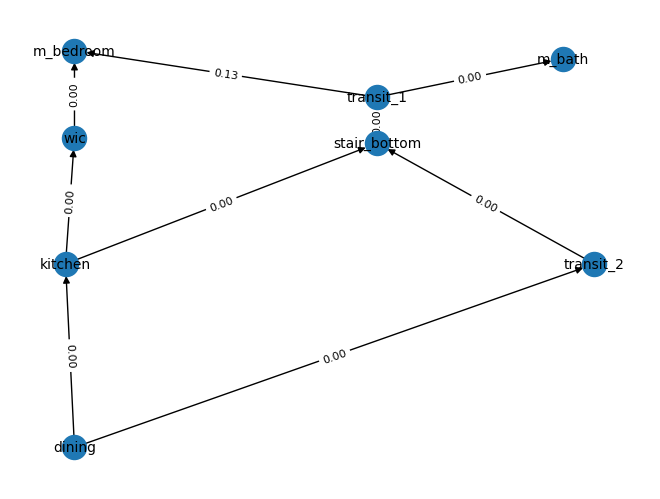

In [39]:
draw_digraph(Gy, domains=domains)

## running fixer

In [82]:
report_problems(Layout(ad, graphs))

[Problem(ix=0, HOLE, ['kitchen', 'corridor'], resolved=False,  n_actions=2,
 Problem(ix=1, HOLE, ['linen', 'laundry'], resolved=False,  n_actions=2,
 Problem(ix=2, HOLE, ['bed1_closet', 'bed1'], resolved=False,  n_actions=2,
 Problem(ix=3, HOLE, ['m_closet', 'm_bed'], resolved=False,  n_actions=2,
 Problem(ix=4, HOLE, ['linen', 'transit'], resolved=False,  n_actions=2]

In [83]:
playout = Layout(ad, graphs)

In [84]:
re = Reporter(playout)
re.run()

In [85]:
c = Cook(re)

initializing.. 0
running again -> 1
next best layout m_closet-STRETCH-for-HOLE near ['m_closet', 'm_bed']4-PS:2.22-S:3.11


In [86]:
c.run_again()

running again -> 2
next best layout bed1_closet-STRETCH-for-HOLE near ['bed1_closet', 'bed1']3-PS:1.12-S:2.06


In [87]:
c.run_again()

running again -> 3
next best layout linen-STRETCH-for-HOLE near ['linen', 'transit']2-PS:1.00-S:1.50


In [88]:
c.run_again()

running again -> 4
next best layout linen-STRETCH-for-HOLE near ['linen', 'laundry']1-PS:0.26-S:0.63


In [89]:
c.run_again()

running again -> 5
next best layout kitchen-PULL-for-HOLE near ['kitchen', 'corridor']1-PS:0.12-S:0.56


In [90]:
c.run_again()

running again -> 6
next best layout dining-SQUEEZE-for-OVERLAP near ['kitchen', 'dining']0-PS:0.06-S:0.03


In [91]:
c.plot_all()

n_rows 3, n_sols: 6
len sols = 6+1. Len indices = 9


In [92]:
c.bl_hist[-1]

node: dining, action: SQUEEZE, summary: Counter(), # unres probs: 0

In [93]:
plot_general(c.bl_hist[-1].layout.domains)

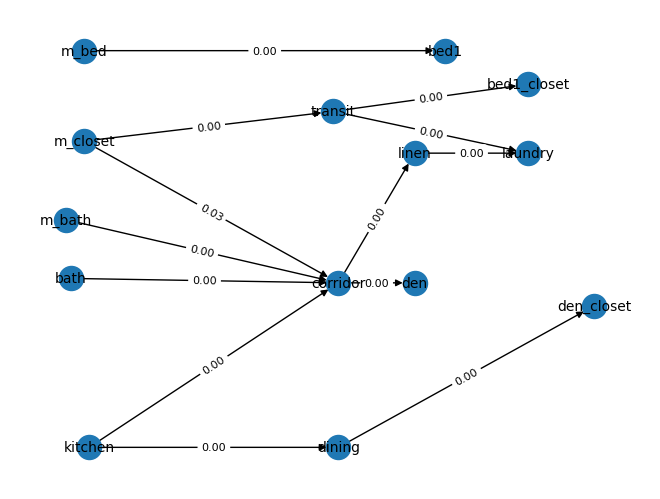

In [100]:
res_doms = c.bl_hist[-1].layout.domains
Gxr = create_graph(res_doms, "x") 
Gyr = create_graph(res_doms, "y") 
draw_digraph(Gxr, domains=res_doms)

In [98]:
set(Gxr.edges).difference(set(Gx.edges))

{('m_closet', 'corridor')}

In [101]:
set(Gyr.edges).difference(set(Gy.edges))

{('living', 'den_closet'), ('m_bath', 'transit')}

In [95]:
# save_pickle(c.bl_hist[-1].layout, "overlap_1011")